In [2]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/altro_rocket/Project.toml`


In [3]:
using LinearAlgebra
using StaticArrays
using Printf
using Altro
using RobotDynamics
const RD = RobotDynamics
using TrajectoryOptimization
const TO = TrajectoryOptimization
using Plots
using ForwardDiff  # needed for @autodiff
using FiniteDiff   # needed for @autodiff
import RobotDynamics: AbstractModel
using RobotDynamics: @autodiff

In [4]:
## ---------------------ROCKET LANDING--------
#Define a Discrete Dynamics model using RobotDynamics.jl
@autodiff struct Rocket <: RobotDynamics.DiscreteDynamics end

RD.state_dim(::Rocket) = 6
RD.control_dim(::Rocket) = 3

#RK4 integrator with free time and slack controls 
function RD.discrete_dynamics!(model::Rocket, x_next, x, u, t, h)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0;  
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    x_next .= A*x + B*u + f*1
    return nothing     
end
function RD.discrete_dynamics(model::Rocket, x, u, t, h)
    
    #T makes x_next the dual variable type in order to use ForwardDiff
    T = promote_type(eltype(x), eltype(u))
    x_next = zeros(T, size(x, 1))
    RD.discrete_dynamics!(model::Rocket, x_next, x, u, t, h)
    return x_next
end
#redefine the copy function to work with discrete dynamics
function Base.copy(model::Rocket)
    return Rocket()
end

In [9]:
#Create the RobotDynamics model
model = Rocket()

#obtain the size of the model (states, controls)
nx, nu = size(model)
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
tf = (N-1)*dt
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Qk = 10e-1
Rk = 1e-0
Qfk = 100

Q = Diagonal(@SVector fill(Float64(Qk), nx))
R = Diagonal(@SVector fill(Float64(Rk), nu))
Qf = Diagonal(@SVector fill(Float64(Qfk), nx))
obj = LQRObjective(Q,R,Qf,xg,N)

# CONSTRAINT
cons = ConstraintList(nx,nu,N)

ncx = 2*nx*1
ncu = 2*nu*1
ncg = 1

if ncg > 0
    add_constraint!(cons, GoalConstraint(xg), N)
end
if ncu > 0
    u_min = -10.0*ones(nu)
    u_max =  105.0*ones(nu)
    bnd = BoundConstraint(nx, nu, u_min=u_min, u_max=u_max)
    add_constraint!(cons, bnd, 1:N-1)
end
if ncx > 0
    # state is x y v θ
    x_min = [-5,-5,0,-10,-10,-10.0]
    x_max = [5,5,20,10,10,10.0]
    bnd1 = BoundConstraint(nx, nu, x_min=x_min, x_max=x_max)
    add_constraint!(cons, bnd1, 1:N)
end

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [[0;0;100.0] for k = 1:N-1]
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

# SOLVE
prob = Problem(model, obj, x0, tf, xf=xg, constraints=cons, N=N, U0=U)

# initial_controls!(prob, U)
# rollout!(prob);

solver = ALTROSolver(prob)
set_options!(solver, 
    constraint_tolerance = 1e-4,
    cost_tolerance = 1e-2,
    cost_tolerance_intermediate = 1e-1,
    gradient_tolerance = 10.0,
    gradient_tolerance_intermediate = 1.0,

    # expected_decrease_tolerance = 1e-2,
    # iterations_inner = 1,
    # dJ_counter_limit = 10,
    # square_root = false,
    # line_search_lower_bound = 1e-8,
    # line_search_upper_bound = 10.0,
    # line_search_decrease_factor = 0.5,
    # iterations_linesearch = 10,
    # max_cost_value = 1.0e8,
    # max_state_value = 1.0e8,
    # max_control_value = 1.0e8,
    # static_bp = true,
    # save_S = false,
    # closed_loop_initial_rollout = false,

    # bp_reg = false,
    # bp_reg_initial = 0.0,
    # bp_reg_increase_factor = 1.6,
    # bp_reg_max = 1.0e8,
    # bp_reg_min = 1.0e-8,
    # bp_reg_type = :control,
    # bp_reg_fp = 10.0,

    # use_conic_cost = false,
    # penalty_initial = 1.0,
    # penalty_scaling = 10.0,
    # penalty_max = 1e8,
    # dual_max = 1e8,
    # active_set_tolerance_al = 1e-3,
    # iterations_outer = 30,
    # kickout_max_penalty = false,
    # reset_duals= true,
    # reset_penalties = true,

    # force_pn = false,
    # verbose_pn = false,
    # n_steps = 2,
    # solve_type = :feasible,
    # projected_newton_tolerance = 1e-3,
    # active_set_tolerance_pn = 1e-3,
    # multiplier_projection = true,
    # ρ_chol = 1e-2,     # cholesky factorization regularization
    # ρ_primal = 1.0e-8, # primal regularization
    # ρ_dual = 1.0e-8,   # regularization for multiplier projection 
    # r_threshold = 1.1,    

    projected_newton = false,
#     reuse_jacobians = false,
#     trim_stats = true,  # disable if you want to call methods after solve that add to history
#     iterations = 1000,   # max number of iterations
#     show_summary = true, 
    verbose = 3)

set_options!(solver, projected_newton=false, verbose=3)
solve!(solver);
X_altro = states(solver)
U_altro = controls(solver);

iter  AL iter iLQR iter cost            ||v||     expected  dJ        grad      z         α         ρ         info                                    
——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
1                       1333523.761     2.53e+01  6.73e+05  6.80e+05  2.12e+01  1.01      1.00e+00  1.00e-08                                          
2                       1329034.294     2.36e+01  4.77e+03  4.49e+03  8.63e-01  0.94      1.00e+00  1.00e-08                                          
3                       1328918.200     2.35e+01  1.16e+02  1.16e+02  1.51e-03  1.00      1.00e+00  1.00e-08                                          
4                       1328918.199     2.35e+01  1.72e-03  1.72e-03  2.43e-06  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                 
5     1                 1364250.440     1.98e+01  2.16e+04  1.74e+04  1.30e-01  0.81      1.00

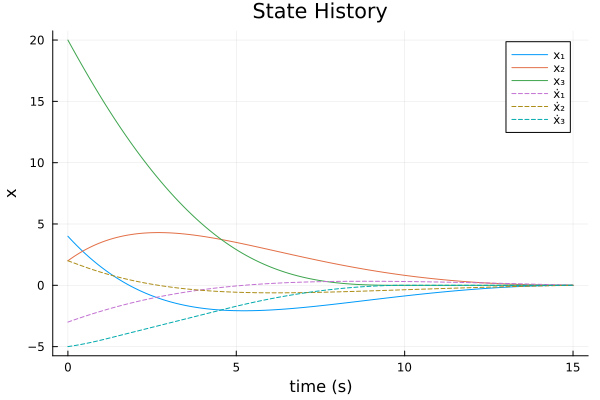

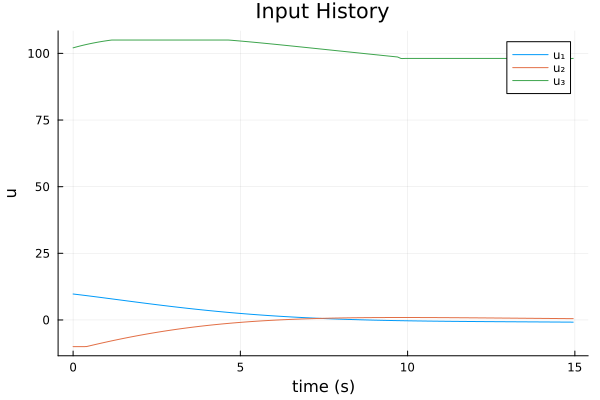

In [8]:
Un = hcat(Vector.(U_altro)...)
Xn = hcat(Vector.(X_altro)...)
display(plot(t_vec,Xn',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Un',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))